In [5]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy

import kontrol
import vishack

prefix = "../data/ham4/ham4_all_sensors_"
suffix = ".xml"

dates = []  # All dates on feb, 2025. exclude 4th and 12th (outlier).
for i in range(1, 29):
    if i != 12 and i != 4:
        dates.append(f"202502{i:02d}")

datas = []
for date in dates:
    path = prefix + date + suffix
    datas.append(vishack.data.diaggui.Diaggui(path))

In [6]:
channels = [
    "L1:ISI-HAM4_BLND_GS13Y_IN1_DQ",
    "L1:ISI-HAM4_BLND_CPSY_IN1_DQ",
    "L1:ISI-GND_STS_ITMY_Y_DQ",
    "L1:ISI-HAM4_FF_Y_IN1_DQ",
]

# L4C and STS coherent subtraction gives seismometer noise
s = control.tf("s")
seis_cal = 1e-9 * 1/s

seismics = []
residuals = []


for data in datas:
#     f, inert_raw = data.psd(channels[0])
    f, rel_raw = data.psd(channels[1])
    _, seis_raw = data.psd(channels[2])
    _, l4c_raw = data.psd(channels[3])
    _, coh = data.coh(channels[2], channels[3])
    
    seismic = seis_raw * abs(seis_cal(1j*2*np.pi*f))
    residual = (seismic**2 * (1-coh**.5))**.5
    seismics.append(seismic)
    residuals.append(residual)

In [7]:
# Find mean, sigma spectrums
seismics = np.array(seismics)
mean = 10**np.mean(np.log10(seismics), axis=0)

def percentile_spectrum(spectrums, percentile):
    """Returns spectrum at percentile:
    
    Parameters
    ----------
    spectrums : list of array
        The spectrums.
    percentile : float
        The percentile.
    
    Returns
    -------
    quantile : array
        The spectrum at percentile.
    """
    spectrums = np.array(spectrums)
    log_spectrums = np.log10(spectrums)
    log_mean = np.mean(log_spectrums, axis=0)
    log_sigma = np.std(log_spectrums, axis=0)
    # quantile function
    log_quantile = log_mean + log_sigma*np.sqrt(2)*scipy.special.erfinv(2*percentile-1)
    quantile = 10**log_quantile
    
    return quantile



In [8]:
seismic_50 = percentile_spectrum(seismics, 0.5)
seismic_75 = percentile_spectrum(seismics, 0.75)
seismic_90 = percentile_spectrum(seismics, 0.9)

residual_50 = percentile_spectrum(residuals, 0.5)
residual_75 = percentile_spectrum(residuals, 0.75)
residual_90 = percentile_spectrum(residuals, 0.9)

# Resample
f_ = np.logspace(-3, 2, 1024)

seismic_50r = np.interp(f_, f, seismic_50)
seismic_75r = np.interp(f_, f, seismic_75)
seismic_90r = np.interp(f_, f, seismic_90)

residual_50r = np.interp(f_, f, residual_50)
residual_75r = np.interp(f_, f, residual_75)
residual_90r = np.interp(f_, f, residual_90)

Text(0.5, 0, 'Frequency (Hz)')

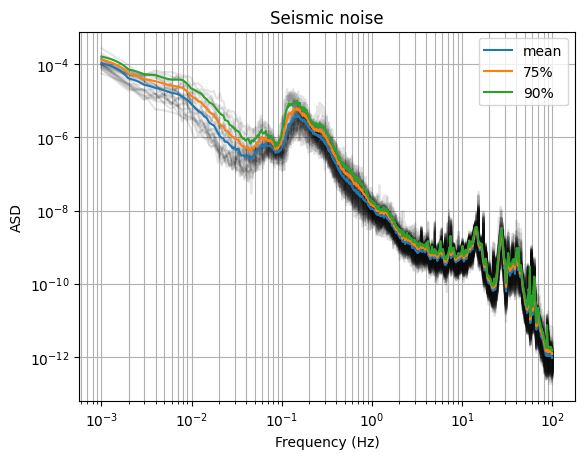

In [9]:
plt.title("Seismic noise")

for seismic in seismics:
    plt.loglog(f, seismic, "k", alpha=0.1)
    
plt.loglog(f_, seismic_50r, label="mean")
plt.loglog(f_, seismic_75r, label="75%")
plt.loglog(f_, seismic_90r, label="90%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

In [12]:
# Export seismic
np.savez("noise_spectrums/ham4/seismic_mean.npz", f=f_, asd=seismic_50r)
np.savez("noise_spectrums/ham4/seismic_75.npz", f=f_, asd=seismic_75r)
np.savez("noise_spectrums/ham4/seismic_90.npz", f=f_, asd=seismic_90r)

Text(0.5, 0, 'Frequency (Hz)')

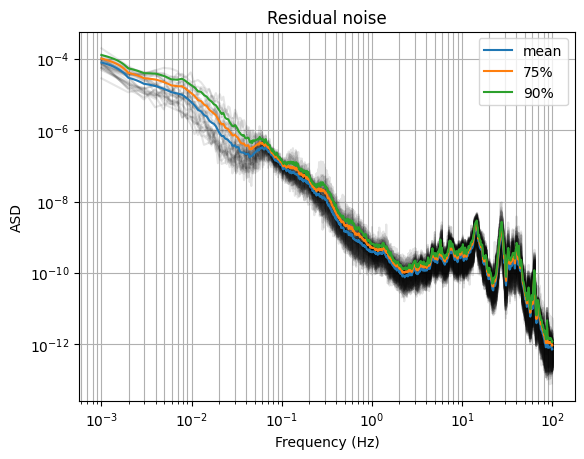

In [13]:
plt.title("Residual noise")

for residual in residuals:
    plt.loglog(f, residual, "k", alpha=0.1)
    
plt.loglog(f_, residual_50r, label="mean")
plt.loglog(f_, residual_75r, label="75%")
plt.loglog(f_, residual_90r, label="90%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

In [14]:
np.savez("noise_spectrums/ham4/seismometer_90.npz", f=f_, asd=residual_90r)
# np.savez("noise_spectrums/ham4/seismic_75.npz", f=f_, asd=seismic_75r)
# np.savez("noise_spectrums/ham4/seismic_90.npz", f=f_, asd=seismic_90r)

In [194]:
seismic_50r_pad = seismic_50r.copy()
seismic_50r_pad[f_<0.043] = seismic_50r[f_>0.043][0]
seismic_50r_pad[f_>1] = seismic_90r[f_<1][-1]

seismic_75r_pad = seismic_75r.copy()
seismic_75r_pad[f_<0.043] = seismic_75r[f_>0.043][0]
seismic_75r_pad[f_>1] = seismic_90r[f_<1][-1]

seismic_90r_pad = seismic_90r.copy()
seismic_90r_pad[f_<0.043] = seismic_90r[f_>0.043][0]
seismic_90r_pad[f_>1] = seismic_90r[f_<1][-1]


residual_50r_pad = residual_50r.copy()
residual_50r_pad[f_<0.003] = residual_50r[f_>0.003][0]
residual_50r_pad[f_>1] = residual_90r[f_<1][-1]

residual_75r_pad = residual_75r.copy()
residual_75r_pad[f_<0.003] = residual_75r[f_>0.003][0]
residual_75r_pad[f_>1] = residual_90r[f_<1][-1]

residual_90r_pad = residual_90r.copy()
residual_90r_pad[f_<0.003] = residual_90r[f_>0.003][0]
residual_90r_pad[f_>1] = residual_90r[f_<1][-1]

Text(0.5, 0, 'Frequency (Hz)')

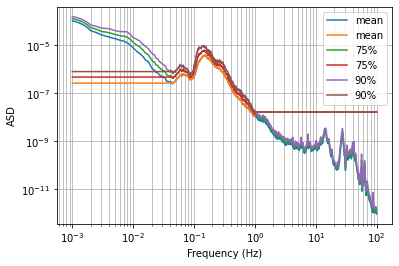

In [195]:
plt.loglog(f_, seismic_50r, label="mean")
plt.loglog(f_, seismic_50r_pad, label="mean")
plt.loglog(f_, seismic_75r, label="75%")
plt.loglog(f_, seismic_75r_pad, label="75%")
plt.loglog(f_, seismic_90r, label="90%")
plt.loglog(f_, seismic_90r_pad, label="90%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

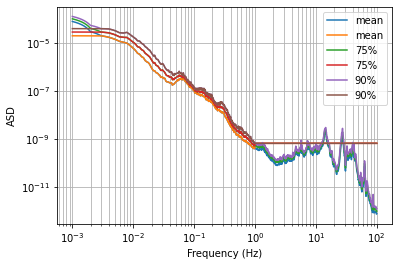

In [196]:
plt.loglog(f_, residual_50r, label="mean")
plt.loglog(f_, residual_50r_pad, label="mean")
plt.loglog(f_, residual_75r, label="75%")
plt.loglog(f_, residual_75r_pad, label="75%")
plt.loglog(f_, residual_90r, label="90%")
plt.loglog(f_, residual_90r_pad, label="90%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

In [197]:
#Fit

seismic_50r_fit = kontrol.curvefit.spectrum_fit(f_, seismic_50r_pad, nzero=4, npole=4)
seismic_75r_fit = kontrol.curvefit.spectrum_fit(f_, seismic_75r_pad, nzero=6, npole=6)
seismic_90r_fit = kontrol.curvefit.spectrum_fit(f_, seismic_90r_pad, nzero=6, npole=6)

residual_50r_fit = kontrol.curvefit.spectrum_fit(f_, residual_50r_pad, nzero=4, npole=4)
residual_75r_fit = kontrol.curvefit.spectrum_fit(f_, residual_75r_pad, nzero=4, npole=4)
residual_90r_fit = kontrol.curvefit.spectrum_fit(f_, residual_90r_pad, nzero=4, npole=4)

Text(0.5, 0, 'Frequency (Hz)')

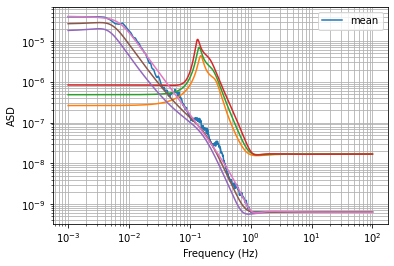

In [199]:

plt.loglog(f_, residual_90r_pad, label="mean")
plt.loglog(f_, abs(seismic_50r_fit(1j*2*np.pi*f_)))
plt.loglog(f_, abs(seismic_75r_fit(1j*2*np.pi*f_)))
plt.loglog(f_, abs(seismic_90r_fit(1j*2*np.pi*f_)))

plt.loglog(f_, abs(residual_50r_fit(1j*2*np.pi*f_)))
plt.loglog(f_, abs(residual_75r_fit(1j*2*np.pi*f_)))
plt.loglog(f_, abs(residual_90r_fit(1j*2*np.pi*f_)))
# plt.loglog(f_, seismic_75r_pad, label="75%")

# plt.loglog(f_, seismic_90r_pad, label="90%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

In [200]:
comp_50 = kontrol.ComplementaryFilter()
comp_50.noise1 = seismic_50r_fit
comp_50.noise2 = residual_50r_fit
comp_50.weight1 = 1/residual_50r_fit
comp_50.weight2 = 1/seismic_50r_fit

comp_50.h2synthesis()
h1_50, h2_50 = comp_50.hinfsynthesis()

In [212]:
comp_75 = kontrol.ComplementaryFilter()
comp_75.noise1 = seismic_50r_fit
comp_75.noise2 = residual_75r_fit
comp_75.weight1 = 1/residual_75r_fit
comp_75.weight2 = 1/seismic_50r_fit

comp_75.h2synthesis()
h1_75, h2_75 = comp_75.hinfsynthesis()

In [213]:
comp_90 = kontrol.ComplementaryFilter()
comp_90.noise1 = seismic_50r_fit
comp_90.noise2 = residual_90r_fit
comp_90.weight1 = 1/residual_90r_fit
comp_90.weight2 = 1/seismic_50r_fit

comp_90.h2synthesis()
h1_90, h2_90 = comp_90.hinfsynthesis()

In [221]:
prefilt = (s/(s+2*np.pi*0.003))**4

h2_50p = prefilt * h2_50
h1_50p = 1-h2_50p

h2_75p = prefilt * h2_75
h1_75p = 1-h2_75p

h2_90p = prefilt * h2_90
h1_90p = 1-h2_90p

In [215]:
cml_bb_sc = kontrol.load_transfer_function("sensor_correction_filters/CML_BB_SC.pkl")

cml_bb_sc *= s

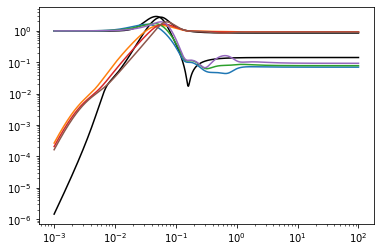

In [222]:
plt.loglog(f_, abs(cml_bb_sc(1j*2*np.pi*f_)), "k")
plt.loglog(f_, abs((1-cml_bb_sc)(1j*2*np.pi*f_)), "k")

plt.loglog(f_, abs(h1_50p(1j*2*np.pi*f_)))
plt.loglog(f_, abs(h2_50p(1j*2*np.pi*f_)))

plt.loglog(f_, abs(h1_75p(1j*2*np.pi*f_)))
plt.loglog(f_, abs(h2_75p(1j*2*np.pi*f_)))

plt.loglog(f_, abs(h1_90p(1j*2*np.pi*f_)))
plt.loglog(f_, abs(h2_90p(1j*2*np.pi*f_)))

In [225]:
kontrol.TransferFunction(h2_50).save("sensor_correction_filters/ham4/h_sc_50.pkl")
kontrol.TransferFunction(h2_75).save("sensor_correction_filters/ham4/h_sc_75.pkl")
kontrol.TransferFunction(h2_90).save("sensor_correction_filters/ham4/h_sc_90.pkl")
kontrol.TransferFunction(prefilt).save("sensor_correction_filters/ham4/prefilt.pkl")